## Algorytmy geometryczne – ćwiczenie 3 <br>triangulacja wielokątów monotonicznych

### Funkcje pomocnicze

In [2]:
from geometria import *
import os
import pickle

funkcja licząca wyznacznik, przydatna przy określaniu położenia względnego punktów i określania czy trójkąt należy do figury

In [253]:
def det(a, b, c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - b[0]*a[1] - c[1]*a[0]

tolerancja względem zera:

In [254]:
EPSILON = 1e-12

### Klasyfikacja wierzchołków

* 'start' : początkowe
* 'divide' : łączące
* 'end' : końcowe
* 'link' : łączące
* 'correct' : prawidłowe

In [255]:
def categorize_points(polygon):
    '''
    wierzchołki muszą być podane w kolejności CCW
    zwraca słownik z przyporządkowanymi punktami do kategorii 
    oraz obiekt klasy Plot do wizualizacji
    '''
    
    n = len(polygon)
    categories = {"start": [], "divide": [], "end": [], "link": [], "correct": []}
    
    for i in range(n):
        
        if polygon[i-1][1] < polygon[i][1] and polygon[(i+1)%n][1] < polygon[i][1]:
            det_ = det(polygon[i-1], polygon[i], polygon[(i+1)%n])
            if det_ > EPSILON:
                categories['start'].append(polygon[i])
            elif det_ < -EPSILON:
                categories['divide'].append(polygon[i])
                
        elif polygon[i-1][1] > polygon[i][1] and polygon[(i+1)%n][1] > polygon[i][1]:
            det_ = det(polygon[i-1], polygon[i], polygon[(i+1)%n])
            if det_ > EPSILON:
                categories['end'].append(polygon[i])
            elif det_ < -EPSILON:
                categories['link'].append(polygon[i])
                
        else:
            categories['correct'].append(polygon[i])
                
    plot = Plot(points = [PointsCollection(categories['start'], color='lime'),
                         PointsCollection(categories['end'], color='red'),
                         PointsCollection(categories['link'], color='mediumblue'),
                         PointsCollection(categories['divide'], color='lightskyblue'),
                         PointsCollection(categories['correct'], color='sienna')],
               lines = [LinesCollection([(polygon[i], polygon[(i+1)%n]) for i in range(n)], color='black', zorder=0)])
    
    return categories, plot

In [256]:
with open('polygons_3/classification', 'rb') as f:
    points_to_classify = pickle.load(f)

<IPython.core.display.Javascript object>


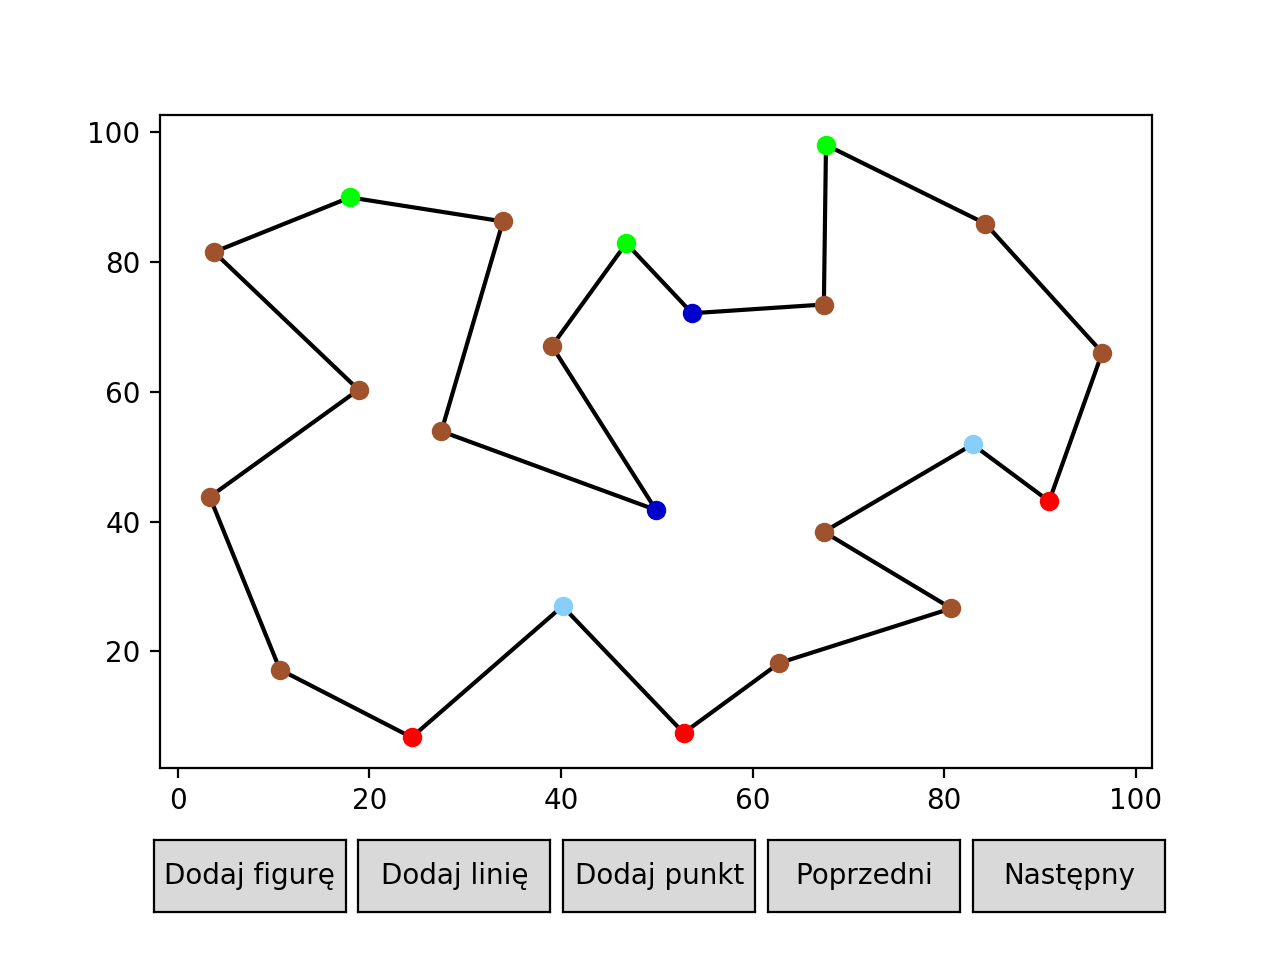

In [257]:
%matplotlib notebook
_, plot = categorize_points(points_to_classify)
plot.draw()

### Y-monotoniczność

Poniżej implementacja dwóch funkcji, których zadaniem jest określenie, czy wielokąt jest ściśle y-monotoniczny.
* <i>is_y_monotonic</i> przechodzi po obu łańcuchach, sprawdzając warunek stale malejącej współrzędnej y
* <i>is_y_monotonic_2</i> korzysta z klasyfikacji punktów

In [258]:
def is_y_monotonic(polygon):
    '''
    polygon: lista wierzchołków w kolejności ccw
    funkcja sprawdza, czy zadany wielokąt jest monotoniczny, 
    przechodząc kolejno po każdym punkcie i sprawdzając jego pozycję w stosunku do punktu poprzedniego 
    '''
    highest_point = max(polygon, key=lambda x: x[1])
    lowest_point = min(polygon, key=lambda x: x[1])
    n = len(polygon)
    
    highest_index = polygon.index(highest_point)
    
    
    # lewy łańcuch
    i = highest_index
    while polygon[i] != lowest_point:
        if polygon[i][1] <= polygon[(i+1)%len(polygon)][1]:
            return False
        i += 1
        i %= n
    
    # prawy łańcuch
    i = highest_index
    while polygon[i] != lowest_point:
        if polygon[i][1] <= polygon[i-1][1]:
            return False
        i -= 1
    
    return True     

is_y_monotonic([(0,0), (1, 1), (0.5, 10), (-7, 1)])

True

In [259]:
def is_y_monotonic_2(polygon):
    '''
    polygon: lista wierzchołków w kolejności ccw
    funkcja sprawdza, czy zadany wielokąt jest monotoniczny, 
    korzystając z klasyfikacji punktów
    '''
    categories, _ = categorize_points(polygon)
    return len(categories['link']) == 0 and len(categories['divide']) == 0
    
is_y_monotonic_2([(0,0), (1, 1), (0.5, 10), (-7, 1)])

True

### Triangulacji wielokąta monotonicznego

In [260]:
LEFT = -1
RIGHT = 1
NEITHER = 0 # punkty o minimalnej i maksymalnej współrzędnej y nie należą do żadnego łańcucha

In [261]:
class Vertex:
    def __init__(self, point, chain = NEITHER):
        self.x = point[0]
        self.y = point[1]
        self.chain = chain
    
    def pos(self):
        return (self.x, self.y)

funkcja pomocnicza wykorzystywana do określania, czy zadany trójkąt mieści się wewnątrz zadanego wieloboku:

In [244]:
def is_triangle_inside(a, b, c):
    '''
    zwraca True jeśli trójkąt o wierzchołkach a b c leży wewnątrz wielokąta
    False wpp
    '''
    det_ = det(a.pos(), b.pos(), c.pos())
    if b.chain == LEFT:
        return det_ > EPSILON
    else:
        return det_ < -EPSILON

pomocnicza funkcja przyporządkowująca punktom ich łańcuch:

In [262]:
def find_chains(polygon):
    '''
    polygon: lista wierzchołków wielokąta w kolejności ccw
    zwraca listę obiektów klasy Vertex, 
    każdy obiekt przechowuje współrzędne punktu oraz informację o łańcuchu, do którego należy
    '''
    n = len(polygon)
    
    highest_point = max(polygon, key=lambda x: x[1])
    lowest_point = min(polygon, key=lambda x: x[1])
    
    highest_index = polygon.index(highest_point)
    lowest_index = polygon.index(lowest_point)
    
    points = [Vertex(highest_point)]
    
    i = (highest_index + 1) % n
    while i != lowest_index:
        points.append(Vertex(polygon[i], LEFT))
        i += 1
        i %= n
    
    points.append(Vertex(lowest_point))
    i = (i+1)%n
    
    while i != highest_index:
        points.append(Vertex(polygon[i], RIGHT))
        i += 1
        i %= n
        
    return points

pomocnicza funkcja sortująca punkty trójkąta w kierunku przeciwnym do ruchu wskazówek zegara: 

In [263]:
def to_ccw(a, b, c):
    '''
    a, b, c: obiekty klasy Vertex
    '''
    if det(a.pos(), b.pos(), c.pos()) > EPSILON:
        return (a.pos(), b.pos(), c.pos())
    return (c.pos(), b.pos(), a.pos())    

główna funkcja do triangulacji wielokąta ściśle monotonicznego:

In [264]:
def triangulate_monotonic(polygon):
    '''
    funcja do triangulacji wielokąta monotonicznego
    zwraca listę scen do wizualizacji
    oraz listę otrzymanych trójkątów
    
    '''
    if not is_y_monotonic(polygon):
        return
    
    n = len(polygon)
    
    points = find_chains(polygon)
    points.sort(key=lambda point: point.y)
    
    stack = [points[-1], points[-2]]
    points = points[:-2]
    
    edges = [(polygon[i], polygon[(i+1)%n]) for i in range(n)] #krawędzie wielokąta
    triangles = []
    
    scenes = [Scene(points=[PointsCollection(polygon, color='royalblue')], 
                    lines=[LinesCollection(edges[:], color='royalblue', zorder=0)])]
    
    while points:
        
        p = points.pop()
        q = stack[-1]
        
        if p.chain != q.chain:
            pre = None
            while stack:
                r = stack.pop()
                if not ((p.pos(), r.pos()) in edges) and not ((r.pos(), p.pos()) in edges):
                    edges.append((p.pos(), r.pos()))
                  
                if pre:
                    triangles.append(to_ccw(r, q, p))
                
                    scenes.append(Scene(points=[PointsCollection(polygon, color='royalblue'),
                                            PointsCollection([p.pos()], color='red')], 
                                    lines=[LinesCollection([edge for edge in edges], color='royalblue', zorder=0),
                                            LinesCollection([(r.pos(),pre.pos()),(pre.pos(), p.pos()), (p.pos(), r.pos())], color='seagreen', zorder=0)]))
                pre = r

        else:
            stack.pop()
            r = stack[-1]
            
            while is_triangle_inside(r, q, p):
                if not ((p.pos(), r.pos()) in edges) and not ((r.pos(), p.pos()) in edges):
                    edges.append((p.pos(), r.pos()))
                    
                triangles.append(to_ccw(r, q, p))
                
                scenes.append(Scene([PointsCollection(polygon, color='royalblue'),
                                     PointsCollection([p.pos()], color='red')], 
                                    [LinesCollection(edges[:], color='royalblue', zorder=0),
                                     LinesCollection([(r.pos(),q.pos()),(q.pos(), p.pos()), (p.pos(), r.pos())], color='seagreen', zorder=0)]))
                q = r
                stack.pop()
                if not stack:
                    break
                r = stack[-1]
                    
        stack.append(q)
        stack.append(p)
     
    scenes.append(Scene([PointsCollection(polygon, color='royalblue')], [LinesCollection(edges[:], color='royalblue', zorder=0)]))
    return scenes, triangles

[((0, 2), (-1, 1.5), (1, 1)), ((-1, 0.5), (1, 1), (-1, 1.5)), ((1, 1), (-1, 0.5), (0, 0))]


<IPython.core.display.Javascript object>


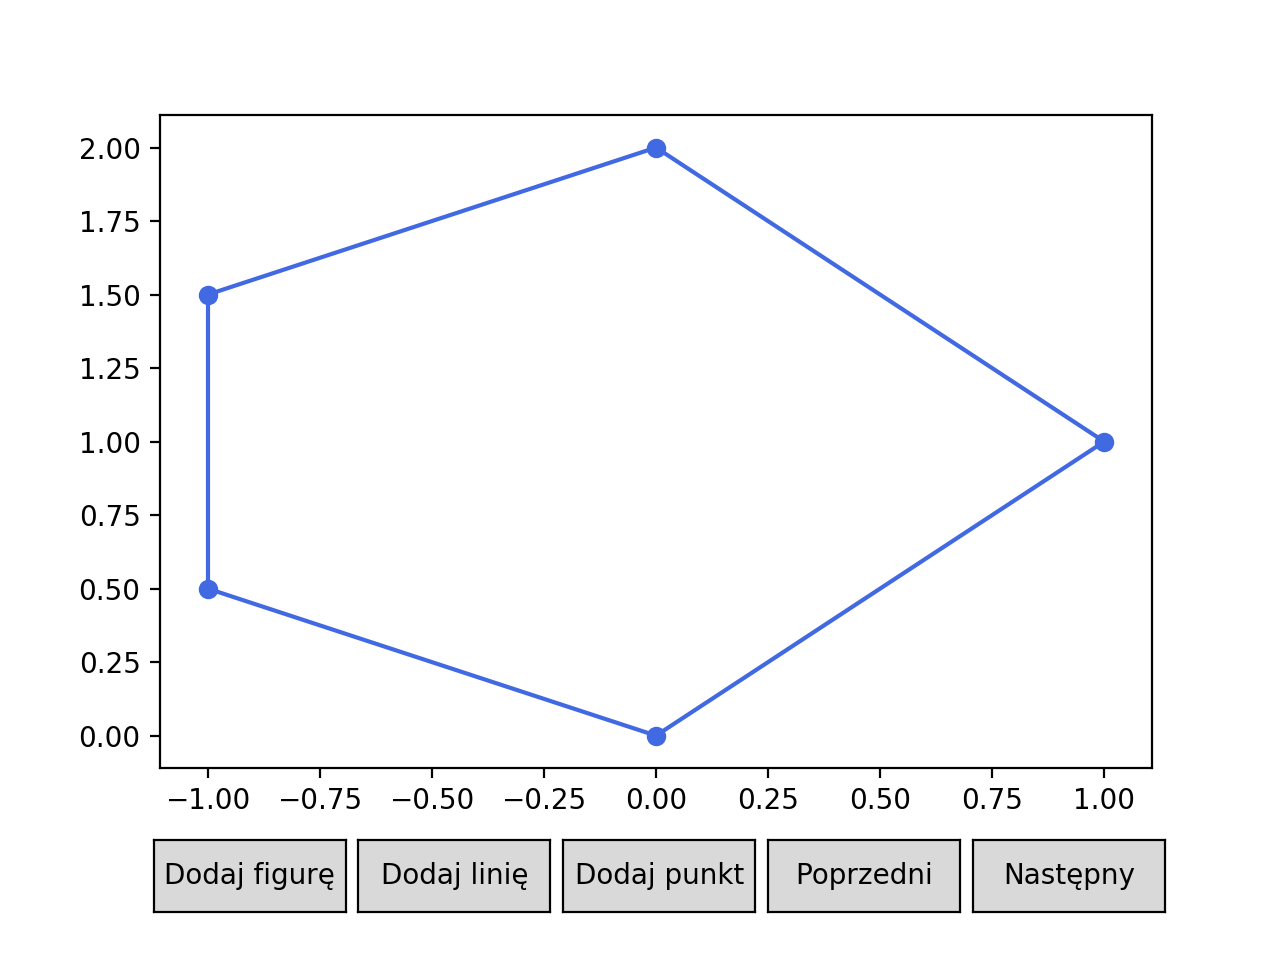

In [265]:
scenes, triangles = triangulate_monotonic([(0,0), (1,1), (0,2), (-1, 1.5), (-1, 0.5)])
print(triangles)
plot = Plot(scenes=scenes)
plot.draw()

### Rysowanie wielokątów

Poniższy kod służy do interaktywnego zadawania punktów, przy pomocy myszki

funkcja <i>get_drawn_points </i> otrzymuje obiekt klasy Plot, na którym uprzednio zaznaczyliśmy nowy wielokąt, klikając w opcję "dodaj figurę". Przechwytuje ona tylko jeden wielokąt, narysowany jako pierwszy. Funkcja dodatkowo zapisuje listę punktów w postaci binarnej w osobnym pliku. Do zapisu i odczytu listy z pliku wykorzystuję bibliotekę <i>pickle</i>.

In [3]:
def get_drawn_points(plot, file_name):
    '''
    plot: obiekt klasy Plot z zaznaczonym wielobokiem
    file_name: string z nazwą pliku do zapisu w folderze 'polygons_3'
    
    '''
    if not plot.get_added_elements().lines:
        return []

    points = [x[0] for x in plot.get_added_elements().lines[0].lines]
    
    with open("polygons_3/"+file_name, 'wb') as f:
        pickle.dump(points, f)
    
    return points

poniższy wykres wykorzystuję do nanoszenia wielokąta:

<IPython.core.display.Javascript object>


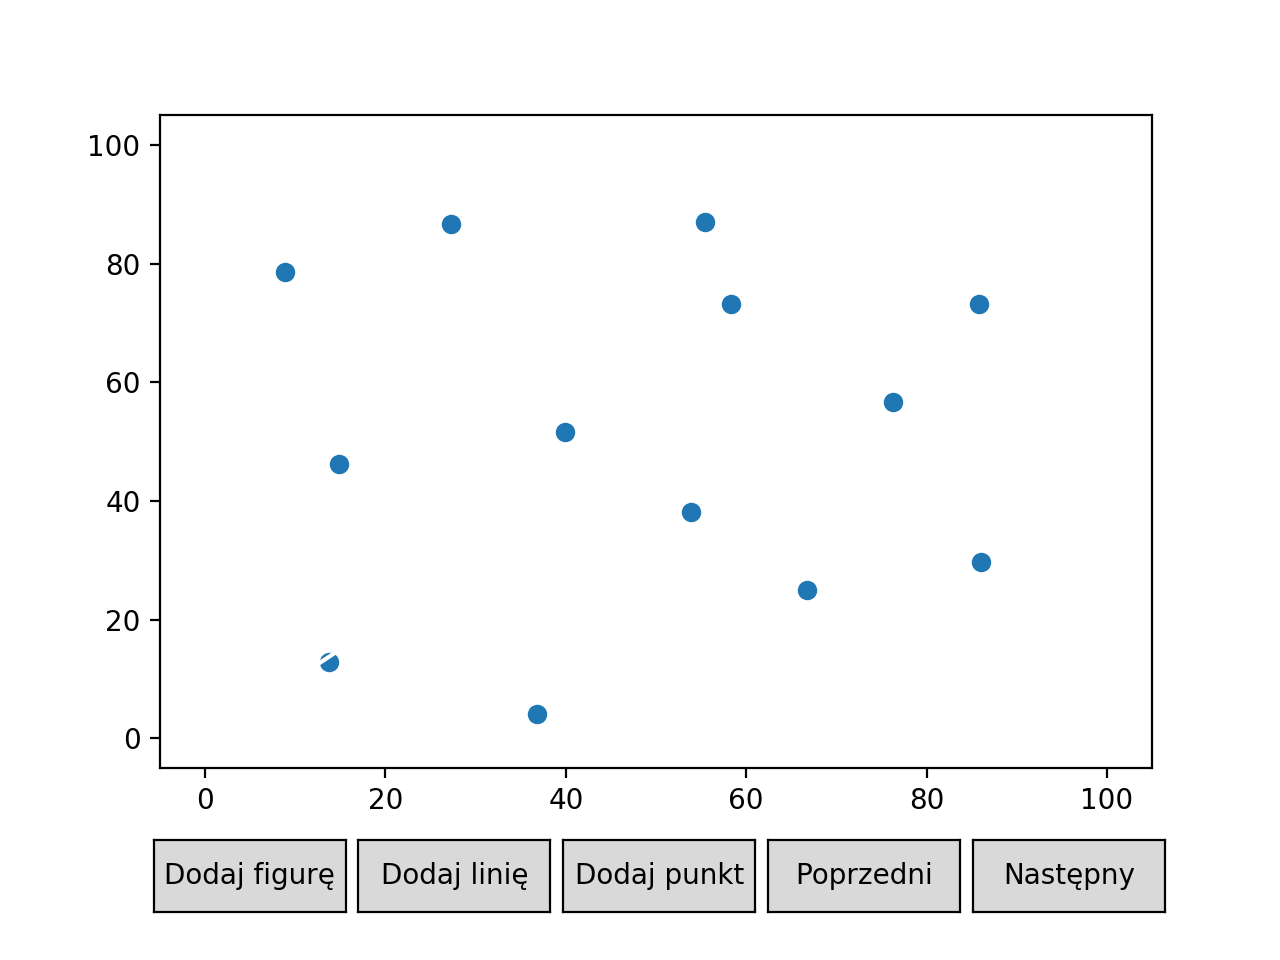

In [4]:
%matplotlib notebook

plot= Plot(lines=[LinesCollection([((0, 0), (100,100))], color='white')])
plot.draw()

In [5]:
plot.get_added_elements().points[0].points

[(27.30626260080645, 86.66666666666666),
 (76.318359375, 56.67279411764705),
 (14.886907762096776, 46.22549019607842),
 (36.842552923387096, 4.099264705882341),
 (39.94739163306451, 51.61764705882353),
 (66.78206905241936, 24.9938725490196),
 (58.35464969758065, 73.18627450980392),
 (8.89900453629032, 78.578431372549),
 (13.77803679435484, 12.861519607843128),
 (53.919165826612904, 38.13725490196078),
 (86.07642389112902, 29.712009803921553),
 (85.85464969758064, 73.18627450980392),
 (55.47158518145161, 87.00367647058823)]

In [268]:
# points_A = get_drawn_points(plot, 'A')
with open('polygons_3/A', 'rb') as f:
    points_A = pickle.load(f)

In [269]:
#points_B = get_drawn_points(plot, 'B')
with open('polygons_3/B', 'rb') as f:
    points_B = pickle.load(f)

In [270]:
# points_C = get_drawn_points(plot, 'C')
with open('polygons_3/C', 'rb') as f:
    points_C = pickle.load(f)

In [271]:
#points_D = get_drawn_points(plot, 'D')
with open('polygons_3/D', 'rb') as f:
    points_D = pickle.load(f)

In [272]:
#points_E = get_drawn_points(plot, 'E')
with open('polygons_3/E', 'rb') as f:
    points_E = pickle.load(f)

In [273]:
points_F = [(4,4), (3,3), (2,2), (1,1), (0,0), ((6,-1))]

In [274]:
# points_G = get_drawn_points(plot, 'G')
with open('polygons_3/G', 'rb') as f:
    points_G = pickle.load(f)

In [275]:
# points_H = get_drawn_points(plot, 'H')
with open('polygons_3/H', 'rb') as f:
    points_H = pickle.load(f)

<IPython.core.display.Javascript object>


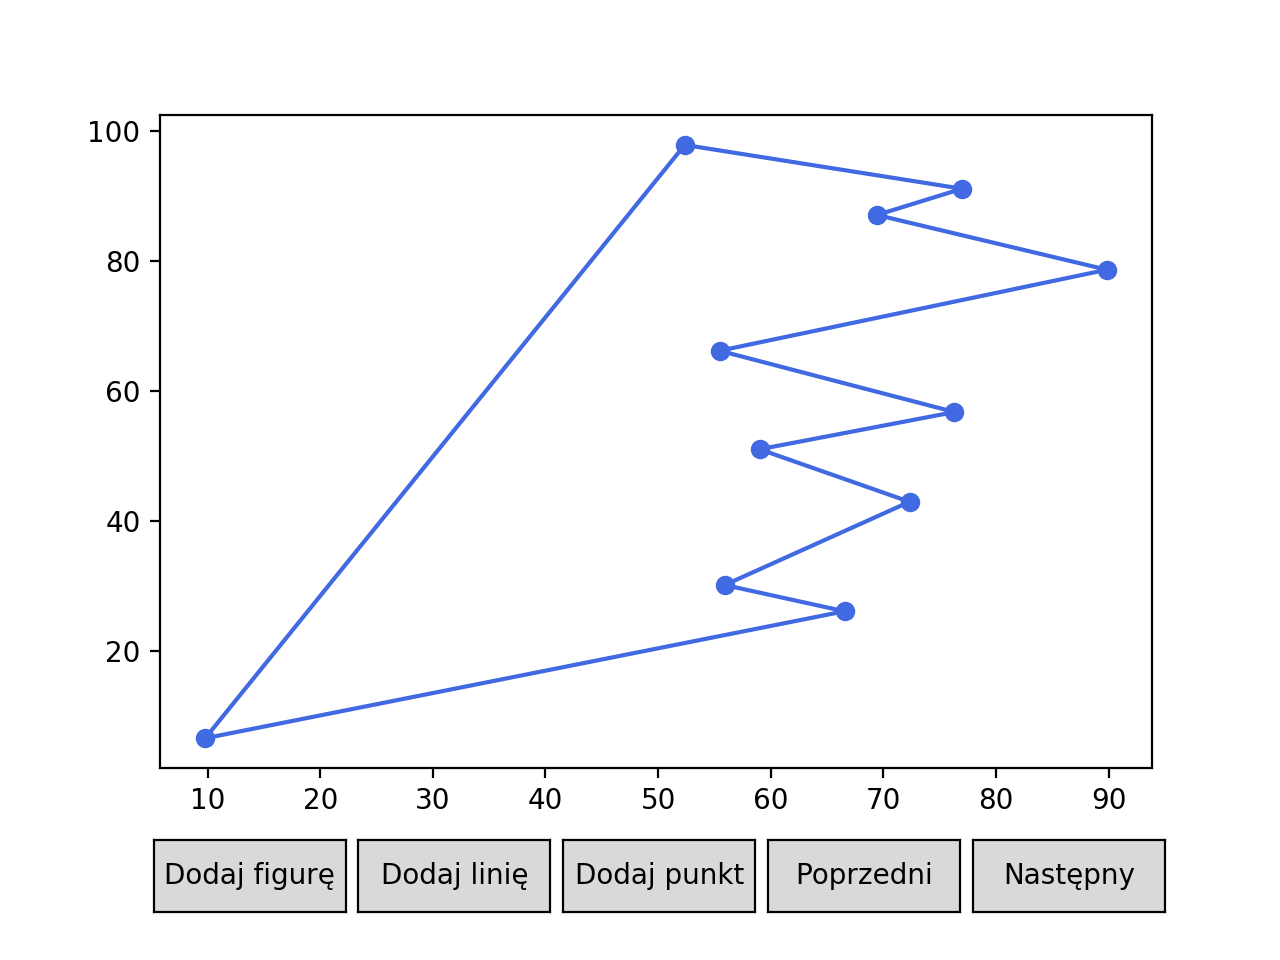

In [276]:
scenes, triangles = triangulate_monotonic(points_A)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


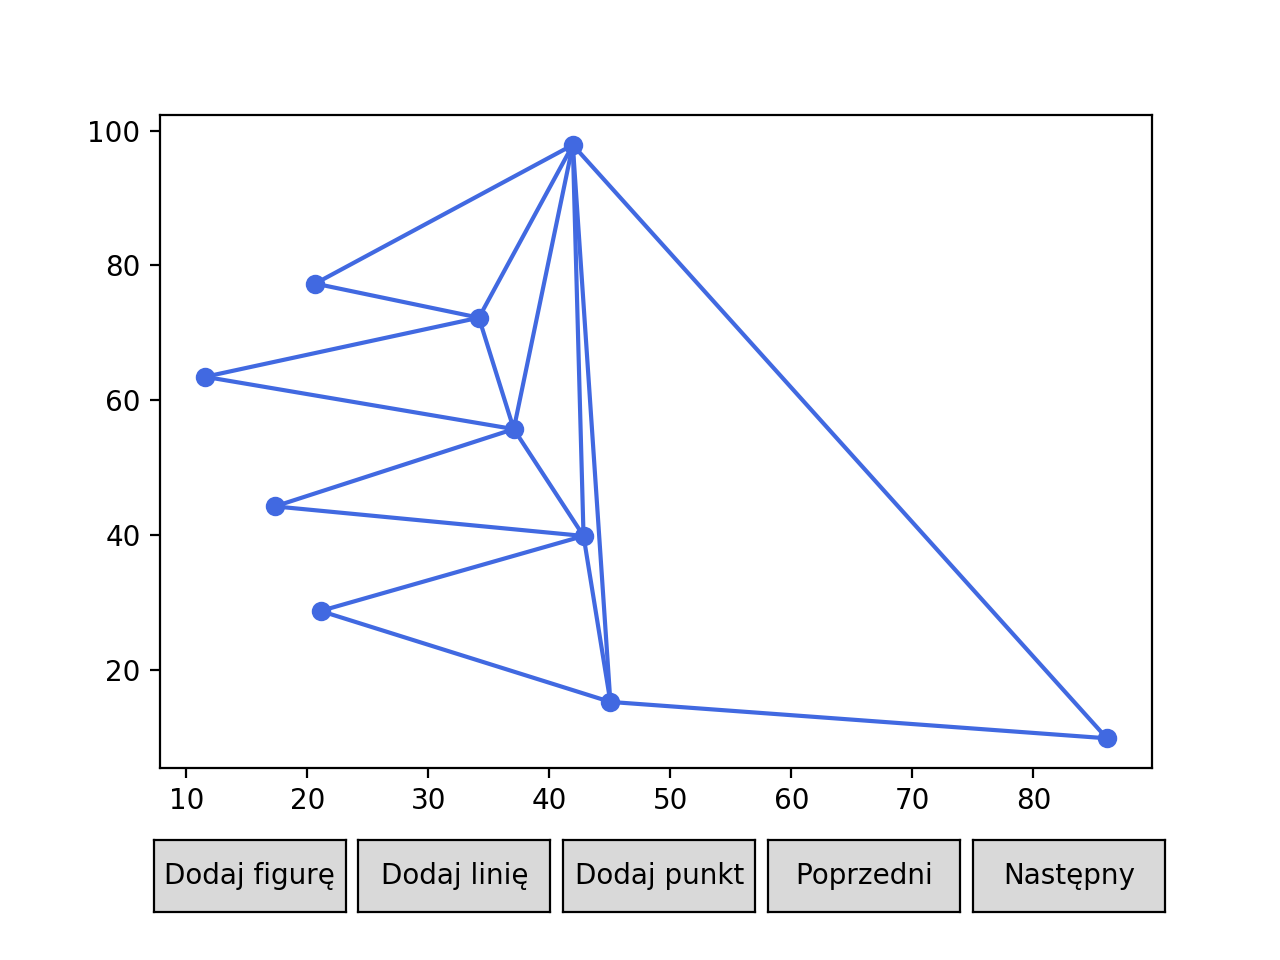

In [277]:
scenes, triangles = triangulate_monotonic(points_B)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


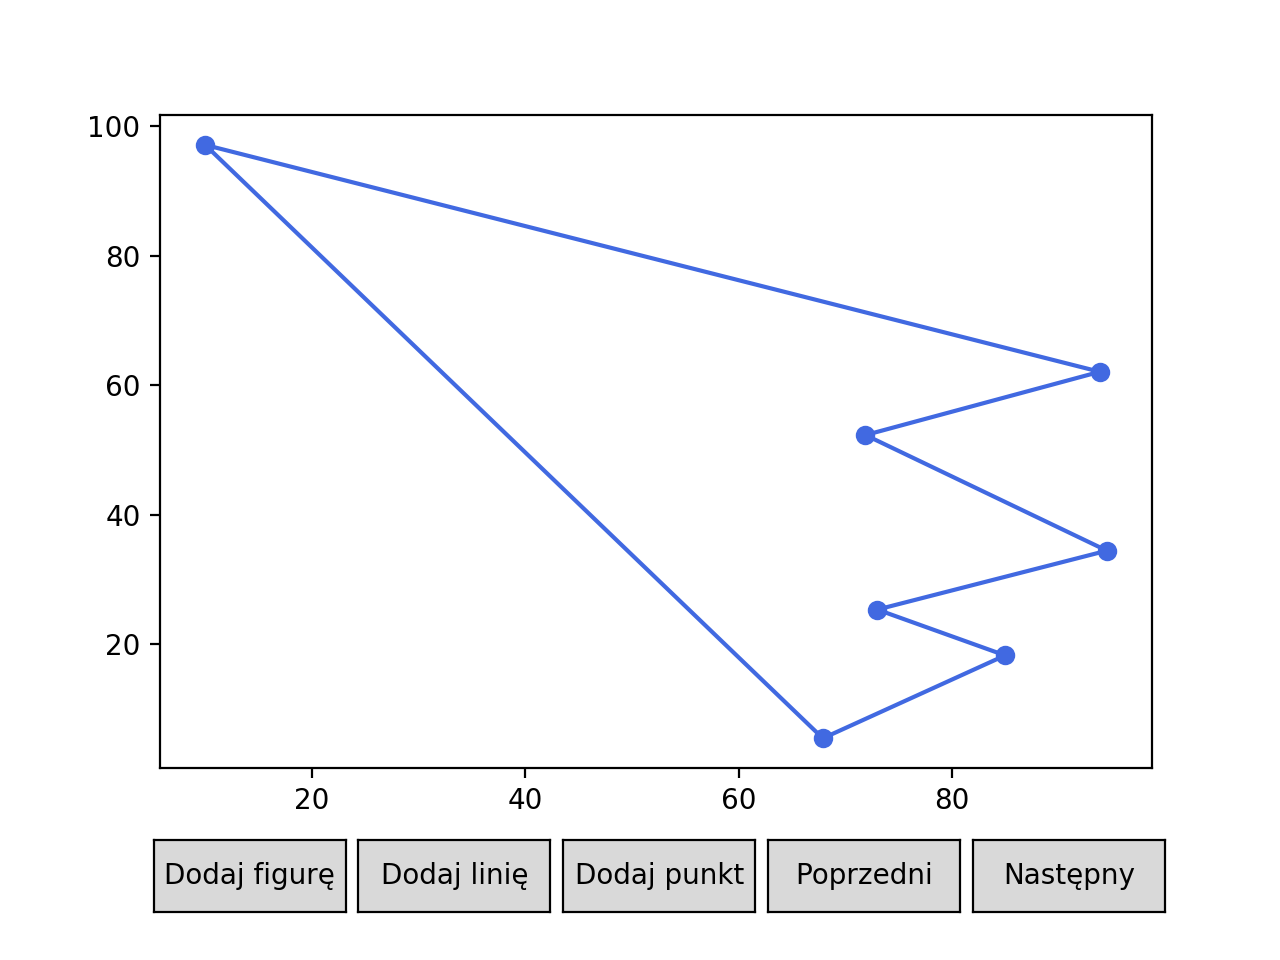

In [278]:
scenes, triangles = triangulate_monotonic(points_H)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


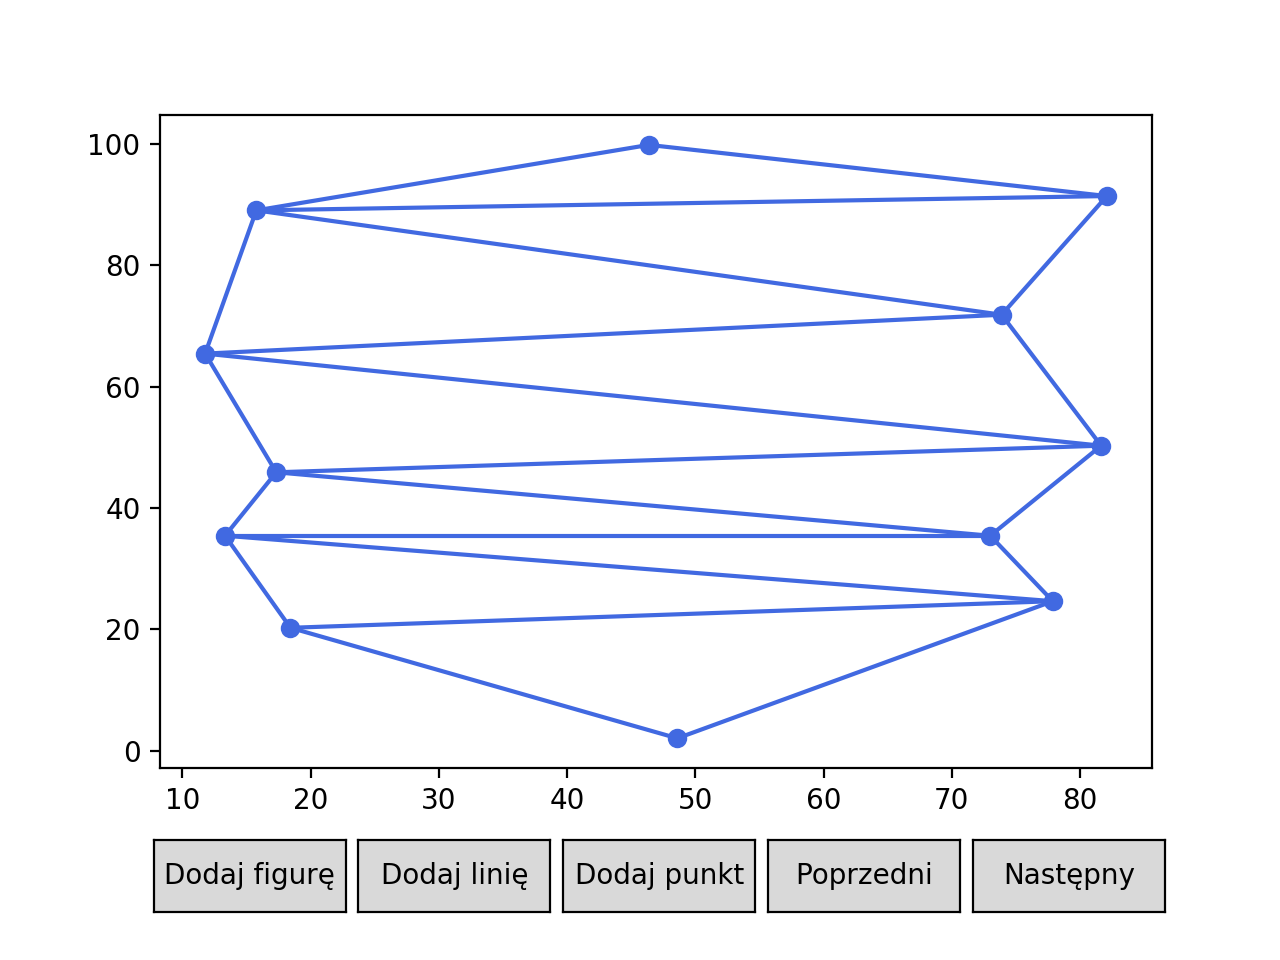

10


In [279]:
scenes, triangles = triangulate_monotonic(points_C)
plot = Plot(scenes=scenes)
plot.draw()
print(len(triangles))

<IPython.core.display.Javascript object>


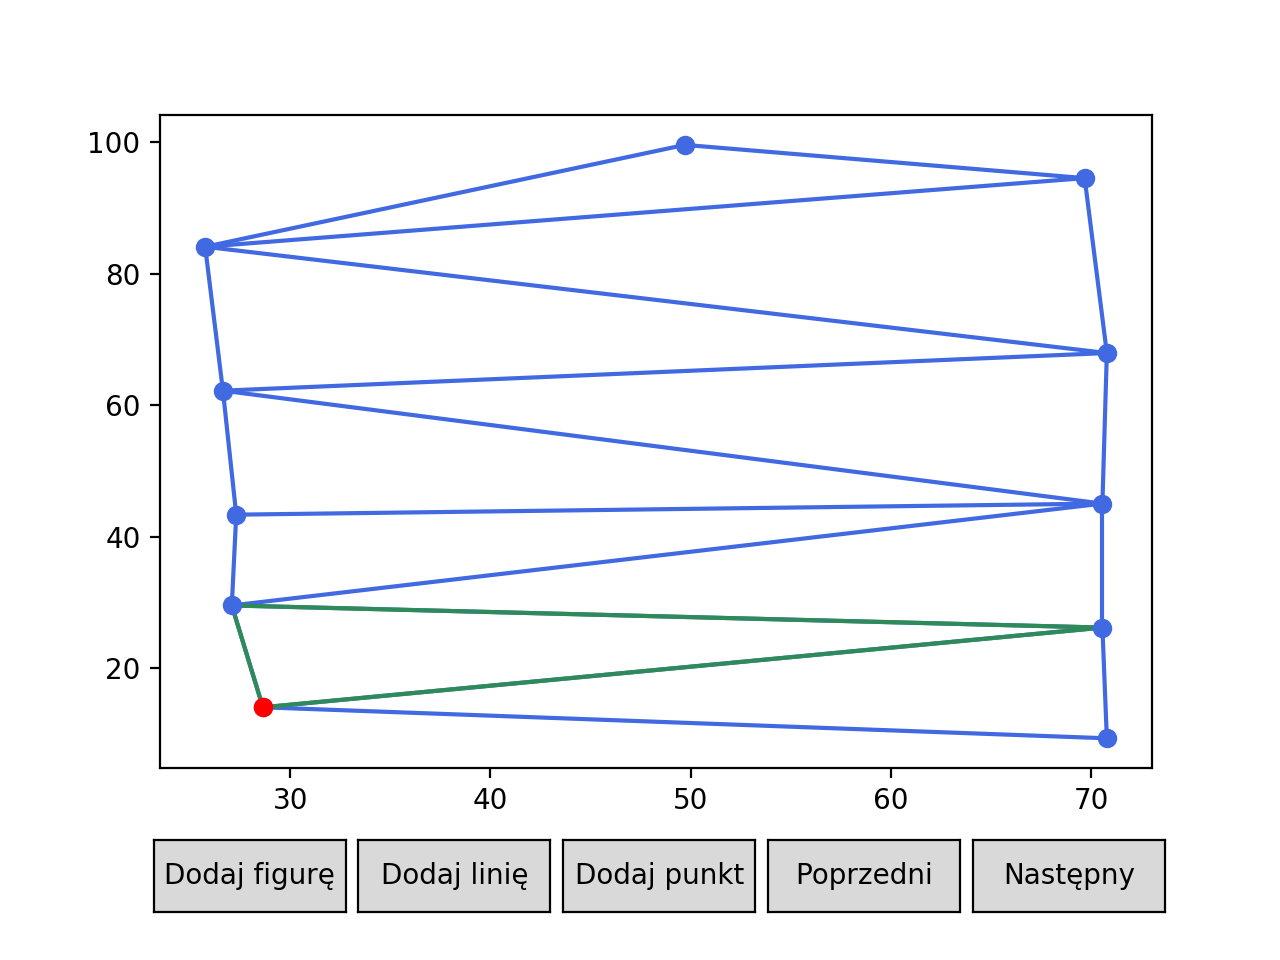

9


In [280]:
scenes, triangles = triangulate_monotonic(points_D)
plot = Plot(scenes=scenes)
plot.draw()
print(len(triangles))

<IPython.core.display.Javascript object>


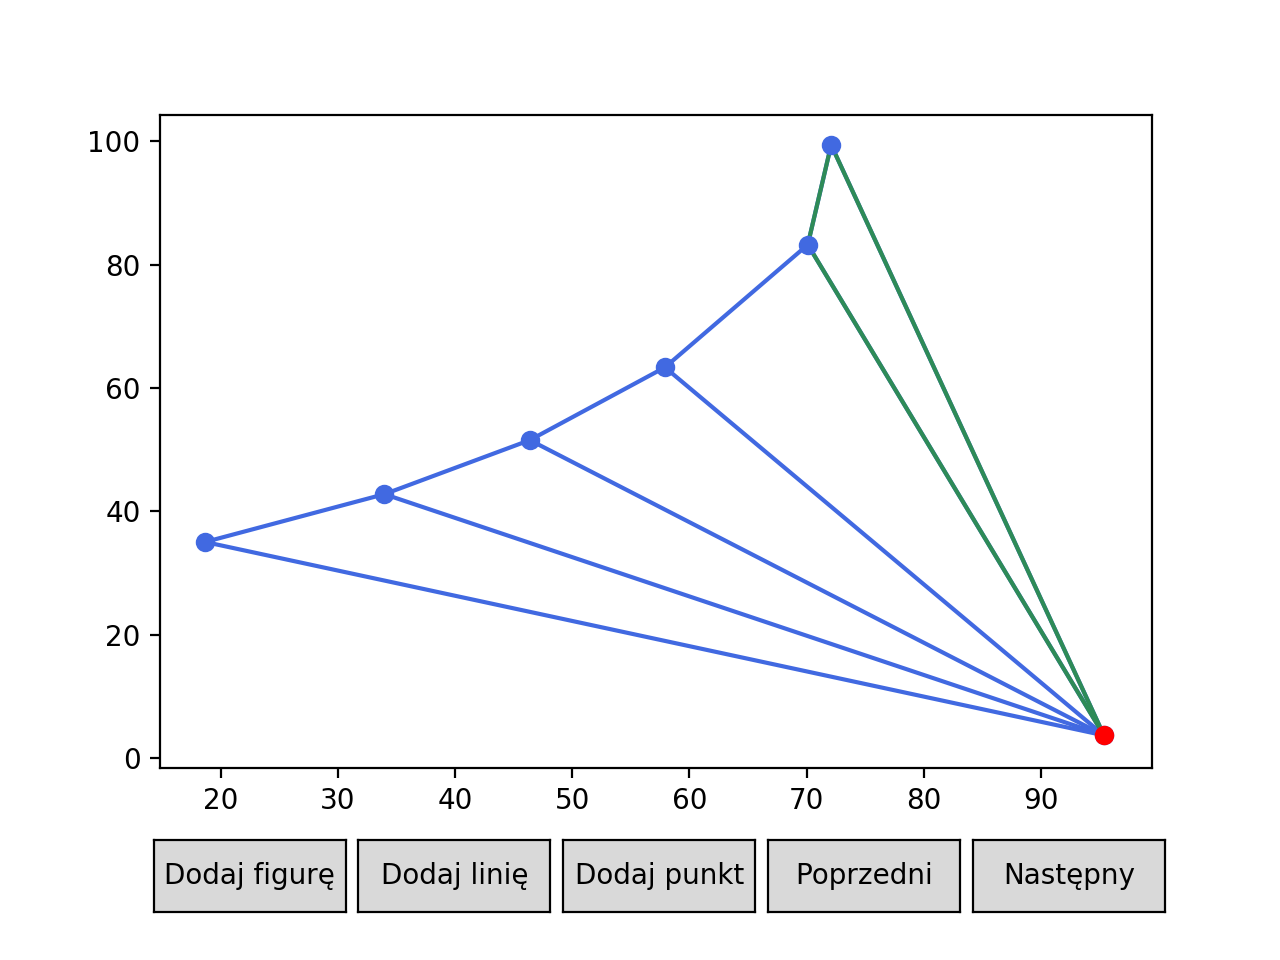

In [281]:
scenes, triangles = triangulate_monotonic(points_E)
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


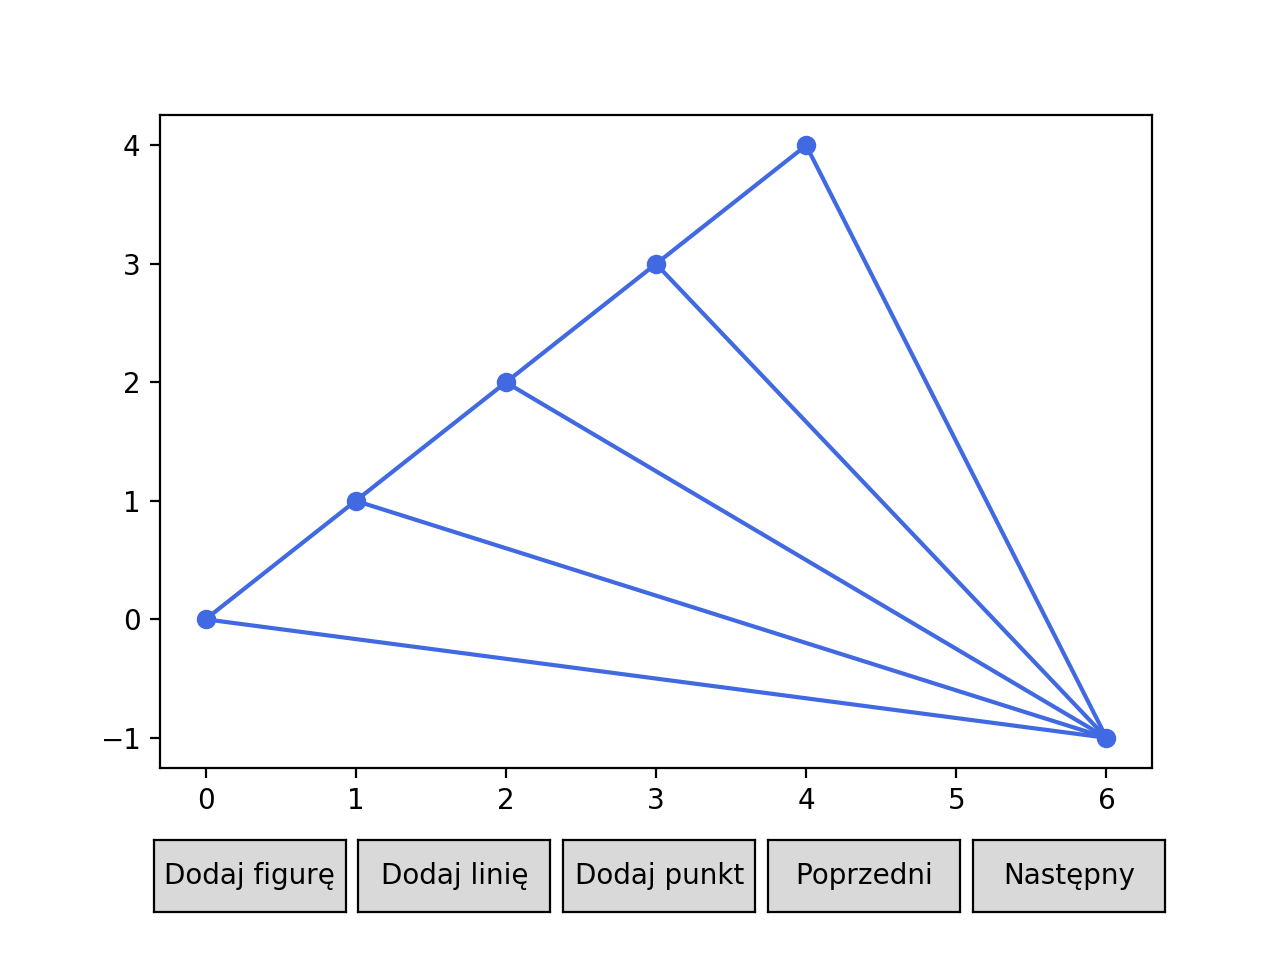

In [282]:
scenes, triangles = triangulate_monotonic(points_F)
plot = Plot(scenes=scenes)
plot.draw()

[((2, 2), (-1, 1), (0, 0))]


<IPython.core.display.Javascript object>


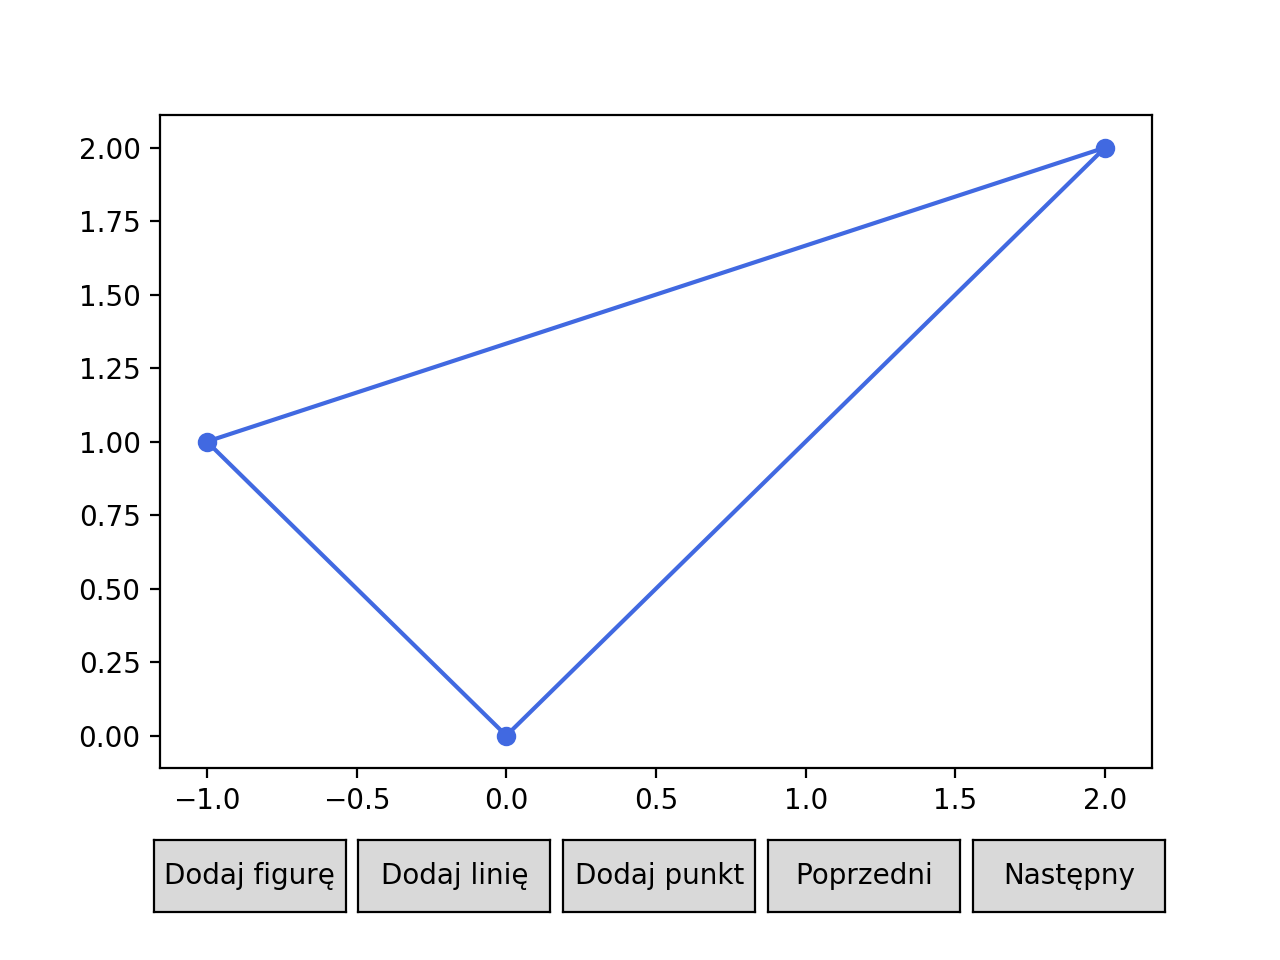

In [283]:
scenes, triangles = triangulate_monotonic([(0,0), (-1,1), (2,2)])
print(triangles)
plot = Plot(scenes=scenes)
plot.draw()

### Animacja

In [284]:
def save_pics(points):
    scenes, _ = triangulate_monotonic(points)
    for i, scene in enumerate(scenes):
        plot = Plot(scenes=[scenes[i]])
        plot.draw()
        plt.savefig(f'plot_3/{i}')

<img src='animacje_2/plot_A.gif'>
<img src='animacje_2/plot_G.gif'>

M. Hawryluk, AGH 2020